# Univariate analysis using NHANES data

In [1]:
# Initial Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
# Use pandas to read csv and create a DataFrame
df = pd.read_csv(Path('data/nhanes_2015_2016.csv'))
df.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


### Data Wrangling

In [3]:
# rename the columns we are interested with useful/meaninful names 
df.rename(columns={'RIAGENDR':'Gender', 
                  'RIDAGEYR':'Age',
                  'DMDMARTL':'Martial_Status'}, inplace = True)

# replace interger code with meaningful text
df['Gender'] = df['Gender'].replace({1:'Male', 2:'Female'})
df['Martial_Status'] = df['Martial_Status'].replace(
    {
        1.0:'Married',
        2.0:'Widowed',
        3.0:'Divorced',
        4.0:'Separated',
        5.0:'Never Married',
        6.0:'Living with partner',
        77.0:"Refused",
        99:None # 99 represents unknown status, equilavent to Nulls
    })

# create a DataFrame with Gender, Age, and Martial_Status column 
df = df[['Age','Gender','Martial_Status']]

# show few rows of data
df.head()

,Age,Gender,Martial_Status
0,62,Male,Married
1,53,Male,Divorced
2,78,Male,Married
3,56,Female,Living with partner
4,42,Female,Divorced


In [4]:
# Summary Statistics of Age 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5735.0,48.05231,18.431011,18.0,32.0,48.0,63.0,80.0


### Frequency Tables
Frequency distribution of martial status among different age groups and gender

In [5]:
df['Martial_Status'].value_counts()

Married                2780
Never Married          1004
Divorced                579
Living with partner     527
Widowed                 396
Separated               186
Refused                   2
Name: Martial_Status, dtype: int64

In [6]:
# Drop rows that have refused category, there are only two here. 
df = df[df['Martial_Status'] != 'Refused']

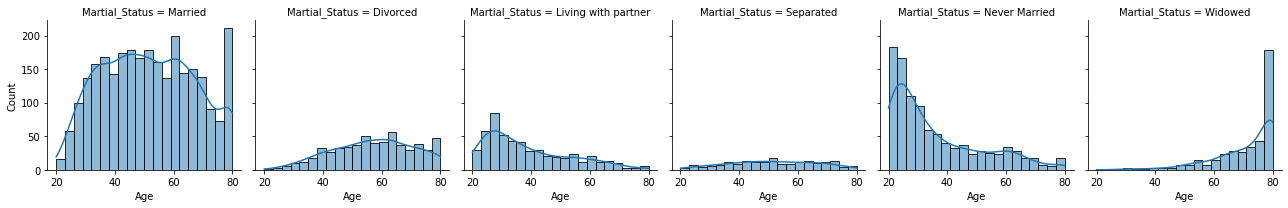

In [7]:
# visualizing dist of martial status among different age groups for all people
sns.displot(data=df, x='Age', col='Martial_Status',binwidth=3, height=3, 
            kde=True,facet_kws=dict(margin_titles=True))
plt.show()

It is easy to notice how martial status changes from one age group to another. For example, the number of never married responses decrease among the older population.

In [8]:
# martial_status for men and women frequncy tables
print('Frequency Table of Male Martial Status')
display(df[df['Gender']=='Male']['Martial_Status'].value_counts().to_frame())
print('Frequency Table of Female Martial Status')
display(df[df['Gender']=='Female']['Martial_Status'].value_counts().to_frame())

Frequency Table of Male Martial Status


,Martial_Status
Married,1477
Never Married,484
Living with partner,265
Divorced,229
Widowed,100
Separated,68


Frequency Table of Female Martial Status


,Martial_Status
Married,1303
Never Married,520
Divorced,350
Widowed,296
Living with partner,262
Separated,118


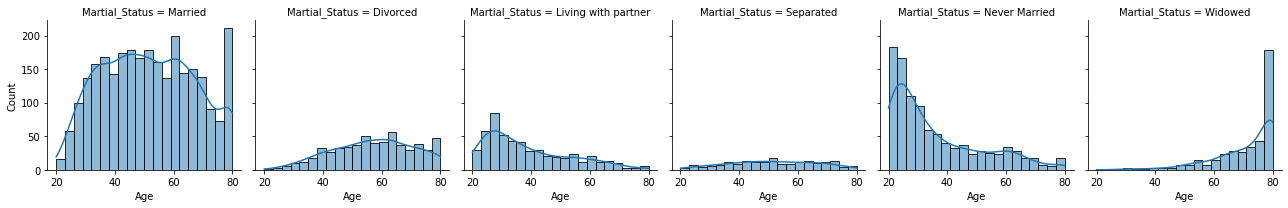

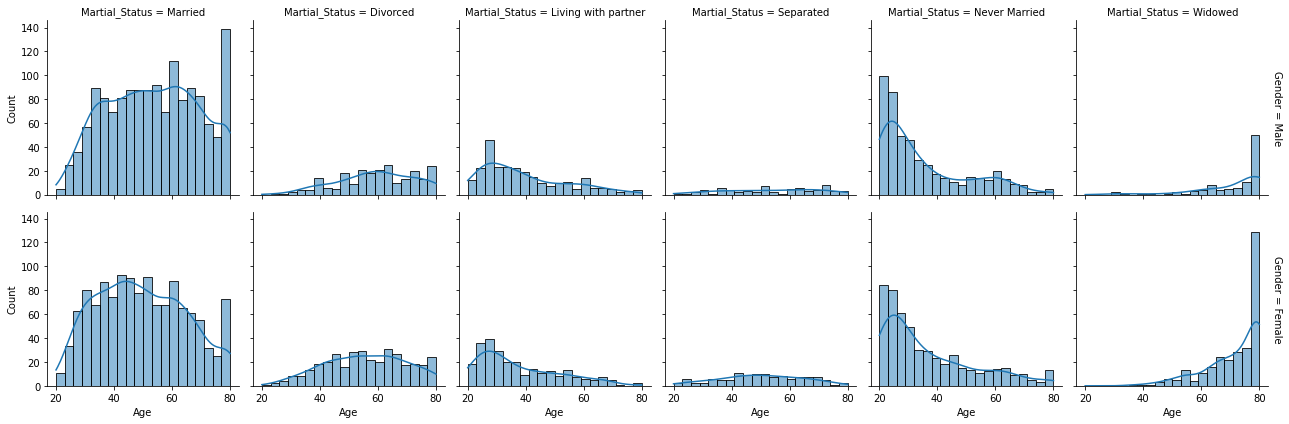

In [9]:
# visualizing dist of martial status among different age groups for male and female
sns.displot(data=df, x='Age', col='Martial_Status',binwidth=3, height=3, 
            kde=True,facet_kws=dict(margin_titles=True))
sns.displot(data=df, x='Age', col='Martial_Status', row='Gender', binwidth=3, height=3, 
            kde=True,facet_kws=dict(margin_titles=True))
plt.show()

One interesting observation from these graphs is that there seems to be a lot more widow statuses for females than males. Other than that, the distributions for both male and female are almost identical to that of the entire population in this study. 

In [10]:
# frequency table for people between 30-40
df[(df['Age']>=30)&(df['Age']<=40)]['Martial_Status'].value_counts().to_frame()

,Martial_Status
Married,560
Never Married,217
Living with partner,143
Divorced,70
Separated,30
Widowed,5


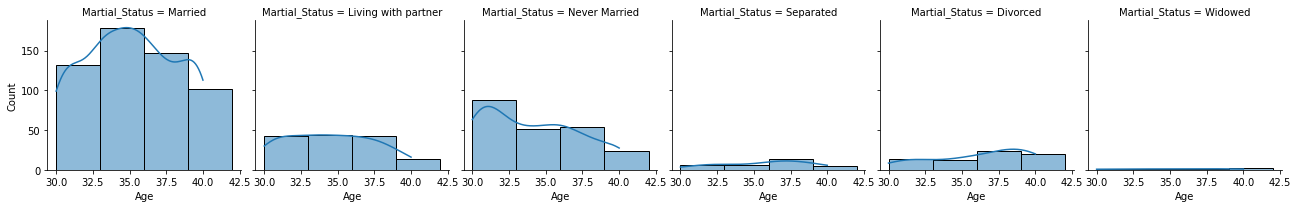

In [11]:
# distribution graphs for people between 30-40
sns.displot(data=df[(df['Age']>=30)&(df['Age']<=40)], x='Age', col='Martial_Status',binwidth=3, height=3, 
            kde=True,facet_kws=dict(margin_titles=True))
plt.show()

Most of the population between the ages 30-40 are married, and widow status is very low among these group 

## Stratification
Examples of how to stratify data into different age groups can be found [here](https://stackoverflow.com/questions/63037485/how-to-segregate-data-in-jupyter-python-3)

In [12]:
# restrict df to female population
female_df = df[df['Gender']=='Female'].copy()
female_df.head()

,Age,Gender,Martial_Status
3,56,Female,Living with partner
4,42,Female,Divorced
5,72,Female,Separated
7,32,Female,Married
12,30,Female,Living with partner


In [13]:
# stratify the subjects into age bands no wider than ten years
# All participants age 80 and above are coded as '80'
female_df['Age_Group'] = pd.cut(female_df['Age'], pd.interval_range(start=0, end=80, freq = 10))
female_df.head()

,Age,Gender,Martial_Status,Age_Group
3,56,Female,Living with partner,"(50, 60]"
4,42,Female,Divorced,"(40, 50]"
5,72,Female,Separated,"(70, 80]"
7,32,Female,Married,"(30, 40]"
12,30,Female,Living with partner,"(20, 30]"


In [14]:
# group data by age and martial status and use pandas agg() to get the count of participants that fall into specific categories
female_df=female_df.groupby(['Age_Group','Martial_Status']).agg({"Age":"count"})      
female_df.rename(columns={'Age':'Frequency'}, inplace = True)
female_df.tail(6)

Frequency
Age_Group Martial_Status                
(70, 80]  Divorced                    59
          Living with partner          3
          Married                    130
          Never Married               21
          Separated                    8
          Widowed                    189

In [15]:
# MULTI-LEVEL INDEX
# level 0 = 'Age_Group' index 
# level 1 = 'Martial_status' index
female_df.groupby(level=0).sum()

,Frequency
Age_Group,
"(0, 10]",0
"(10, 20]",39
"(20, 30]",514
"(30, 40]",474
"(40, 50]",502
"(50, 60]",469
"(60, 70]",441
"(70, 80]",410


In [16]:
# Within each age band, present the distribution in terms of proportions that must sum to 1
female_df = female_df.groupby(level=0).apply(lambda x: x/(float(x.sum()))).round(4).dropna()
female_df.tail(6)

Frequency
Age_Group Martial_Status                
(70, 80]  Divorced                0.1439
          Living with partner     0.0073
          Married                 0.3171
          Never Married           0.0512
          Separated               0.0195
          Widowed                 0.4610

In [17]:
female_df.unstack()

Frequency                                                      \
Martial_Status  Divorced Living with partner Married Never Married Separated   
Age_Group                                                                      
(10, 20]          0.0000              0.2051  0.0256        0.7692    0.0000   
(20, 30]          0.0214              0.2062  0.3054        0.4455    0.0214   
(30, 40]          0.0907              0.1203  0.5443        0.2046    0.0359   
(40, 50]          0.1375              0.0737  0.5737        0.1255    0.0657   
(50, 60]          0.1770              0.0682  0.5480        0.0896    0.0576   
(60, 70]          0.1927              0.0431  0.4807        0.0862    0.0499   
(70, 80]          0.1439              0.0073  0.3171        0.0512    0.0195   

                        
Martial_Status Widowed  
Age_Group               
(10, 20]        0.0000  
(20, 30]        0.0000  
(30, 40]        0.0042  
(40, 50]        0.0239  
(50, 60]        0.0597  
(60, 70]        0.1474  
(70, 80]        0.4610

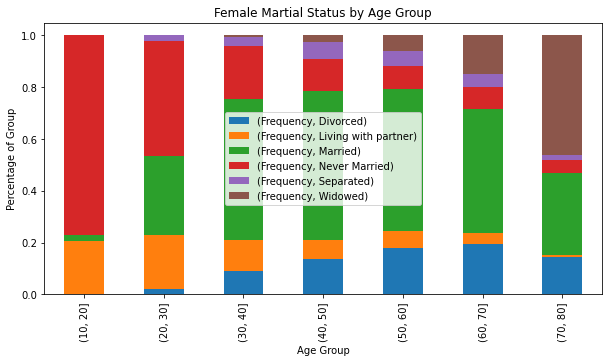

In [18]:
# visualizing dist of martial status among different age groups for all people
female_df.unstack().plot.bar(stacked=True, figsize=(10,5))
plt.title('Female Martial Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Group')
plt.legend()
plt.show()

For the female population, married status is dominant after the age of 30. 

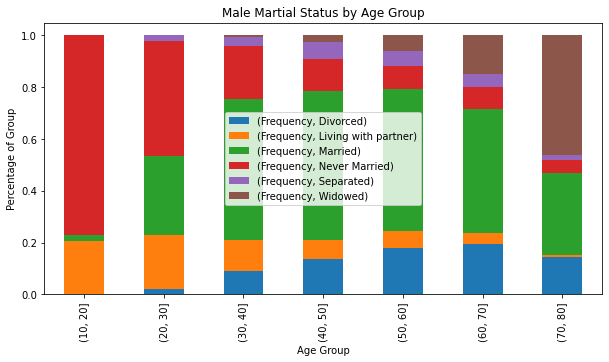

In [19]:
# Repeat the steps from above for the male population
male_df = df[df['Gender']=='Female'].copy()
male_df['Age_Group'] = pd.cut(male_df['Age'], pd.interval_range(start=0, end=80, freq = 10))
male_df=male_df.groupby(['Age_Group','Martial_Status']).agg({"Age":"count"})      
male_df.rename(columns={'Age':'Frequency'}, inplace = True)
male_df = male_df.groupby(level=0).apply(lambda x: x/(float(x.sum()))).round(4).dropna()
male_df.unstack().plot.bar(stacked=True, figsize=(10,5))
plt.title('Male Martial Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Group')
plt.legend()
plt.show()


--- 
## Graphical Summaries
Exploring quantitaive variables

In [20]:
df = pd.read_csv(Path('data/nhanes_2015_2016.csv'))
df.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


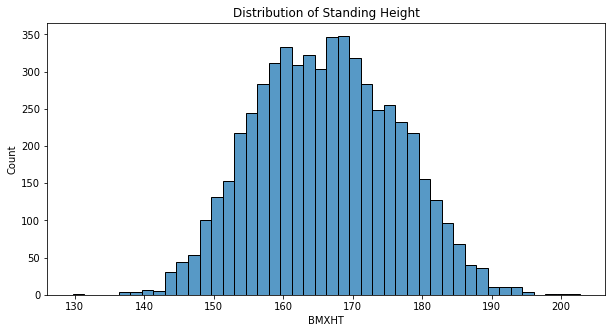

In [23]:
# Histogram of standing height(BMXHT) in cm
plt.figure(figsize=(10,5))
sns.histplot(x = df['BMXHT'])
plt.title('Distribution of Standing Height')
plt.show()

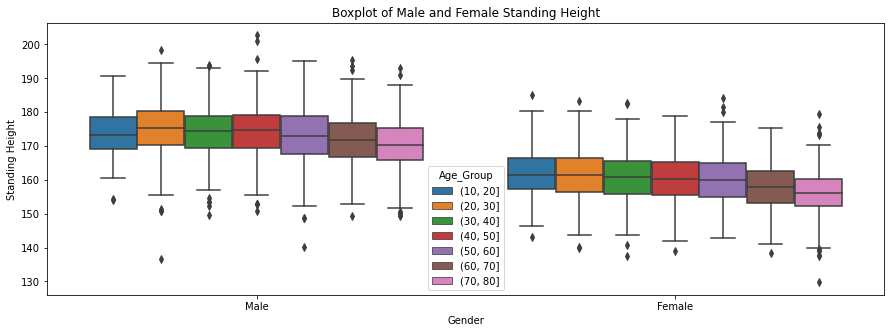

In [24]:
# stratify data set into different age groups
# create boxplot of male and female height
df['Age_Group'] = pd.cut(df['RIDAGEYR'], pd.interval_range(start=10, end=80, freq=10))
plt.figure(figsize=(15,5))
g = sns.boxplot(x=df['RIAGENDR'], y=df['BMXHT'], hue=df['Age_Group'])
g.set_xticklabels(['Male','Female'])
plt.ylabel('Standing Height')
plt.xlabel('Gender')
plt.title('Boxplot of Male and Female Standing Height')
plt.show()